In [1]:
from M1M3tools import *
from datetime import datetime
from datetime import timedelta
from datetime import timezone
import os
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle

plt.style.use('classic')

%matplotlib inline

In [2]:
f1time = [1, 25, 17, 54] #33/28nm surfaces
f3time = [2, 14, 23, 13] #30/26nm surfaces
fatime = [2, 21, 16, 6] #28/24nm surfaces
fbtime = [2, 21, 17, 5] #31/20nm surfaces
fctime = [2, 21, 17, 34] #27/21nm surfaces
fdtime = [2, 21, 22, 49] #28/20nm surfaces

#### Data from test campaign 2 can not be used, because the measured forces are truncated. And, unlike the applied forces, we can not use the cylinder forces to get the same information, because the measured cylinder forces are not saved in EFD tables.

In [3]:
df1 = get_dataframe_EFD(fbtime, 'm1m3_ForceActuatorData')

-------Reading from efdData/MeasuredForces_190221_1705.csv-------------


In [4]:
len(df1['ZForce'][0].split())

146

In [5]:
df1 = get_dataframe_EFD([2,21,22,48], 'm1m3_ForceActuatorData')

-------Reading from efdData/MeasuredForces_190221_2248.csv-------------


In [6]:
len(df1['ZForce'][0].split())

146

In [7]:
# this can even go out of order. df1.date_time, which is the time data is recorded in EFD, is never out of order. 
df1.private_sndStamp[:10]-df1.private_sndStamp[0]

0    0.000000
1    0.020038
2    0.040128
3    0.060034
4    0.080075
5    0.100208
6    0.120144
7    0.140030
8   -0.079979
9    0.160097
Name: private_sndStamp, dtype: float64

#### Let us use data from campaign 1.
Below we only use +/-2 minutes from f1time, and two other random times we grabbed from 190114.ipynb and 190118.ipynb

In [8]:
myt0 = f1time
myt1 = [1,14,22,38] #a random time we grabbed from 190118.ipynb
myt2 = [1,18,16,48]
df1 = get_dataframe_EFD(myt0, table_name = 'm1m3_ForceActuatorData')
df2 = get_dataframe_EFD(myt0, table_name = 'm1m3_logevent_AppliedForces')
df3 = get_dataframe_EFD(myt1, table_name = 'm1m3_ForceActuatorData')
df4 = get_dataframe_EFD(myt1, table_name = 'm1m3_logevent_AppliedForces')
df5 = get_dataframe_EFD(myt2, table_name = 'm1m3_ForceActuatorData')
df6 = get_dataframe_EFD(myt2, table_name = 'm1m3_logevent_AppliedForces')

-------Reading from efdData/MeasuredForces_190125_1754.csv-------------
-------Reading from efdData/AppliedForces_190125_1754.csv-------------
-------Reading from efdData/MeasuredForces_190114_2238.csv-------------
-------Reading from efdData/AppliedForces_190114_2238.csv-------------
-------Reading from efdData/MeasuredForces_190118_1648.csv-------------
-------Reading from efdData/AppliedForces_190118_1648.csv-------------


In [9]:
def assembleFinst(df1, campn, output=0):
    '''
    This function extracts force data from the pandas dataframe (df1), 
    assign the force values to a multi-dimensional array (myF).
    There is no time average of the forces. We store all the instantaneous forces.
    '''
    nn = len(df1.private_sndStamp)
    myF = np.zeros((nn, nActuator, 4)) 
    myF[:,:,0] = actID
    xexist = 1
    yexist = 1
    zexist = 1
    for i in range(nActuator):
        ix = FATABLE[i][FATABLE_XINDEX]
        iy = FATABLE[i][FATABLE_YINDEX]
        if campn == 1:
            try:
                myF[:, i, 3] = df1['ZForces_%d'%(i+1)] #Fz
            except KeyError:
                myF[:, i, 3] = df1['ZForce_%d'%(i+1)] #Fz
        elif campn == 2:
            if len(df1.ZForces)>0 and len(df1.ZForces[0].split())==156:
                myF[:, i, 3] = [float(df1.ZForces[ii].split()[i]) 
                       for ii in range(len(df1.ZForces))]
            else:
                zexist = 0
        if ix != -1:
            # x forces in campn 2 were NOT changed into strings. Only y and z forces
            try:
                myF[:, i, 1] = df1['XForces_%d'%(ix+1)] #Fx, note ix starts with 0
            except KeyError:
                try:
                    myF[:, i, 1] = df1['XForce_%d'%(ix+1)] #Fx, note ix starts with 0
                except KeyError:
                    xexist = 0
        if iy != -1:
            if campn == 1:
                try:
                    myF[:, i, 2] = df1['YForces_%d'%(iy+1)] #Fx, note ix starts with 0
                except KeyError:
                    try:
                        myF[:, i, 2] = df1['YForce_%d'%(iy+1)] #Fx, note ix starts with 0
                    except KeyError:
                        yexist = 0
            elif campn == 2:
                try:
                    myF[:, i, 2] = [float(df1.YForces[ii].split()[iy]) 
                       for ii in range(len(df1.YForces))]
                except AttributeError:
                    zexist = 0
    if not xexist:
        print('---No XForces---')
    if not yexist:
        print('---No YForces---')
    if not zexist:
        print('---No ZForces---')       
    return myF

In [10]:
myf1 = assembleFinst(df1, 1, 1)
myf2 = assembleFinst(df2, 1, 1)
myf3 = assembleFinst(df3, 1, 1)
myf4 = assembleFinst(df4, 1, 1)
myf5 = assembleFinst(df5, 1, 1)
myf6 = assembleFinst(df6, 1, 1)

#### Unfortunately the two force tables have different number of messages.

In [11]:
print(myf1.shape, myf2.shape)

(9393, 156, 4) (9331, 156, 4)


#### The timestamps for sending the messages were different! So we cannot do a simple element-wise subtraction

In [12]:
df2.private_sndStamp[:10]-df2.private_sndStamp[0]

0    0.000000
1    0.120104
2    0.200005
3    0.220149
4    0.240186
5    0.260044
6    0.280007
7    0.300003
8    0.320076
9    0.340201
Name: private_sndStamp, dtype: float64

In [13]:
df1.private_sndStamp[:10]-df1.private_sndStamp[0]

0    0.000000
1    0.080030
2    0.120001
3    0.140130
4    0.160227
5    0.180013
6    0.200007
7    0.219996
8    0.240054
9    0.260207
Name: private_sndStamp, dtype: float64

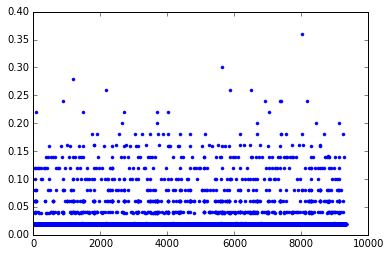

In [14]:
# the time interval varies too
plt.plot(np.array(df2.private_sndStamp[1:]) - np.array(df2.private_sndStamp[:-1]),'.')

#### We set the earliest time stamp to be t=0, and latest time stamp to be tmax. After that we bin the data using the time stamps. 
In example below we choose time interval for averaging to be 1 second.
fdiff is the force difference after binning the data.

In [15]:
t0 = min(min(df1.private_sndStamp), min(df2.private_sndStamp))
tmax = max(max(df1.private_sndStamp), max(df2.private_sndStamp))-t0
t1 = np.array(df1.private_sndStamp - t0)
t2 = np.array(df2.private_sndStamp - t0)

# we could use myt0 to take out the time offset. But, the problem with that is myt0 is the time data recorded in EFD
# here we are looking at time that telemetry was sent. Meanwhile, doing the query using sndStamp is not practical, 
# because it is not always in sequential order.
#[month, day, hour, minute] = myt0
#t0 = datetime(2019, month, day, hour, minute,0)
#t1 = np.array(df1.private_sndStamp - t0.replace(tzinfo=timezone.utc).timestamp())
#t2 = np.array(df2.private_sndStamp - t0.replace(tzinfo=timezone.utc).timestamp())

In [16]:
dt = 1 #1 second interval
nt = int(np.ceil(tmax/dt))

In [17]:
fdiff = np.zeros((nt, nActuator, 4))
for it in range(nt):
    idx1 = np.logical_and(t1>dt*it, t1<dt*(it+1)) #time binning
    idx2 = np.logical_and(t2>dt*it, t2<dt*(it+1)) #time binning
    if np.any(idx1) == True and np.any(idx2) == True:
        #print(np.mean(myf1[idx1,:,:], axis=0).shape)
        # average within time interval
        fdiff[it,:,:] = np.mean(myf1[idx1,:,:], axis=0) - np.mean(myf2[idx2,:,:], axis=0)
    else:
        fdiff[it,:,:] = np.nan
fdiff[:,:,0] = actID  #checked fdiff[:2,:,0]. This is OK.
idxx = ~(np.logical_and(myf1[0,:,1]==0, myf2[0,:,1]==0))#which actuators have x force
idxy = ~(np.logical_and(myf1[0,:,2]==0, myf2[0,:,2]==0))#which actuators have y force
fdiff[:,~idxx,1] = np.nan
fdiff[:,~idxy,2] = np.nan

In [18]:
# do the same thing with df3 and df4. So let's define a function
def get_fdiff_from_myf12(df1, df2, dt=1):
    myf1 = assembleFinst(df1, 1, 1)
    myf2 = assembleFinst(df2, 1, 1)
    
    t0 = min(min(df1.private_sndStamp), min(df2.private_sndStamp))
    tmax = max(max(df1.private_sndStamp), max(df2.private_sndStamp))-t0
    t1 = np.array(df1.private_sndStamp - t0)
    t2 = np.array(df2.private_sndStamp - t0)
    nt = int(np.ceil(tmax/dt))
    fdiff = np.zeros((nt, nActuator, 4))
    for it in range(nt):
        idx1 = np.logical_and(t1>dt*it, t1<dt*(it+1)) #time binning
        idx2 = np.logical_and(t2>dt*it, t2<dt*(it+1)) #time binning
        if np.any(idx1) == True and np.any(idx2) == True:
            fdiff[it,:,:] = np.mean(myf1[idx1,:,:], axis=0) - np.mean(myf2[idx2,:,:], axis=0)
        else:
            fdiff[it,:,:] = np.nan
    fdiff[:,:,0] = actID  #checked fdiff[:2,:,0]. This is OK.
    idxx = ~(np.logical_and(myf1[0,:,1]==0, myf2[0,:,1]==0))#which actuators have x force
    idxy = ~(np.logical_and(myf1[0,:,2]==0, myf2[0,:,2]==0))#which actuators have y force
    fdiff[:,~idxx,1] = np.nan
    fdiff[:,~idxy,2] = np.nan
    return fdiff

In [19]:
fdiff2 = get_fdiff_from_myf12(df3, df4)
fdiff3 = get_fdiff_from_myf12(df5, df6)

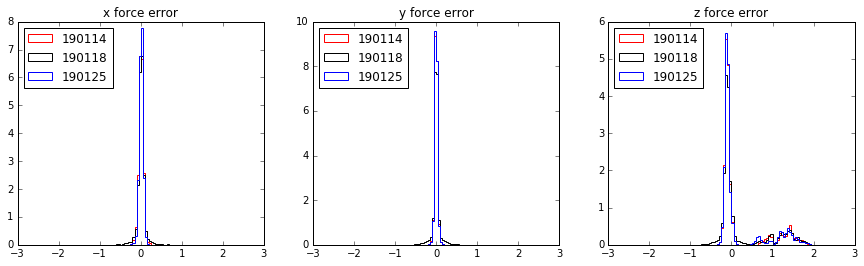

In [20]:
xbin = np.linspace(-2.5,2.5,101)

fig, ax = plt.subplots(1, 3, figsize = (15,4))

idx = ~np.isnan(fdiff2[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff2[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')
ax[1].hist(fdiff2[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')
ax[2].hist(fdiff2[idx,:,3].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')

idx = ~np.isnan(fdiff3[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff3[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')
ax[1].hist(fdiff3[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')
ax[2].hist(fdiff3[idx,:,3].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')

idx = ~np.isnan(fdiff[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
ax[0].hist(fdiff[np.ix_(idx,idxx)][:,:,1].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')
ax[1].hist(fdiff[np.ix_(idx,idxy)][:,:,2].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')
ax[2].hist(fdiff[idx,:,3].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')

ax[0].set_title('x force error')
ax[1].set_title('y force error')
ax[2].set_title('z force error')
for i in range(3):
    ax[i].legend(loc='upper left')

#### We did not use much x or y forces at zenith pointing. They look OK. z-forces have some large differences.
Below we first verify that these large differences are real - indeed in the data.

In [21]:
np.max(fdiff[idx,:,3])

2.0465153664297304

In [22]:
idxt = np.where(fdiff[:,:,3]>2)

In [23]:
idxt

(array([  5, 100]), array([83, 74]))

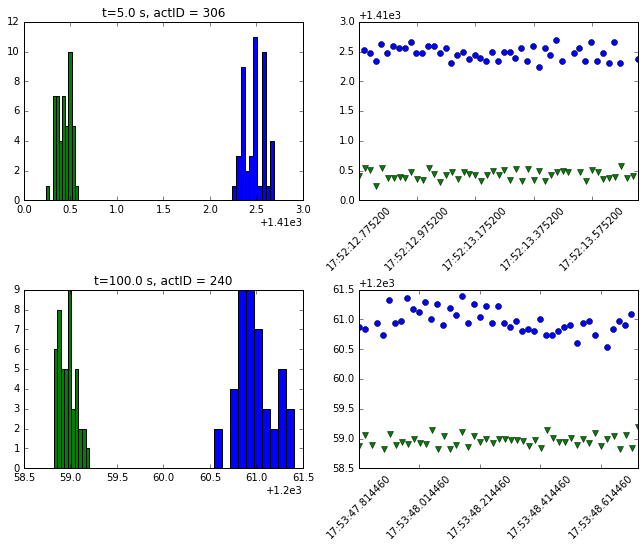

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (11,8))
plt.subplots_adjust(hspace=0.5)
for i in range(2):
    it = idxt[0][i]
    iact = idxt[1][i] #index in the table starts with 1, not 0
    idx1 = np.logical_and(t1>dt*it, t1<dt*(it+1))
    idx2 = np.logical_and(t2>dt*it, t2<dt*(it+1))


    ax[i][0].hist(myf1[idx1, iact, 3])
    ax[i][0].hist(myf2[idx2, iact, 3])
    ax[i][1].plot(pd.to_datetime(df1.private_sndStamp[idx1], unit='s'),df1['ZForce_%d'%(iact+1)][idx1],'o')
    ax[i][1].plot(pd.to_datetime(df2.private_sndStamp[idx2], unit='s'),df2['ZForces_%d'%(iact+1)][idx2],'v')
    ax[i][0].set_title('t=%.1f s, actID = %d'%(it*dt, actID[iact]))
    plt.setp( ax[i][1].xaxis.get_majorticklabels(), rotation=45 )
    #plt.xticks(rotation=45)

#### Are some actuators worse than others? Yes, there are systematic difference, which are small though.
#### Are they changing over time? Not much

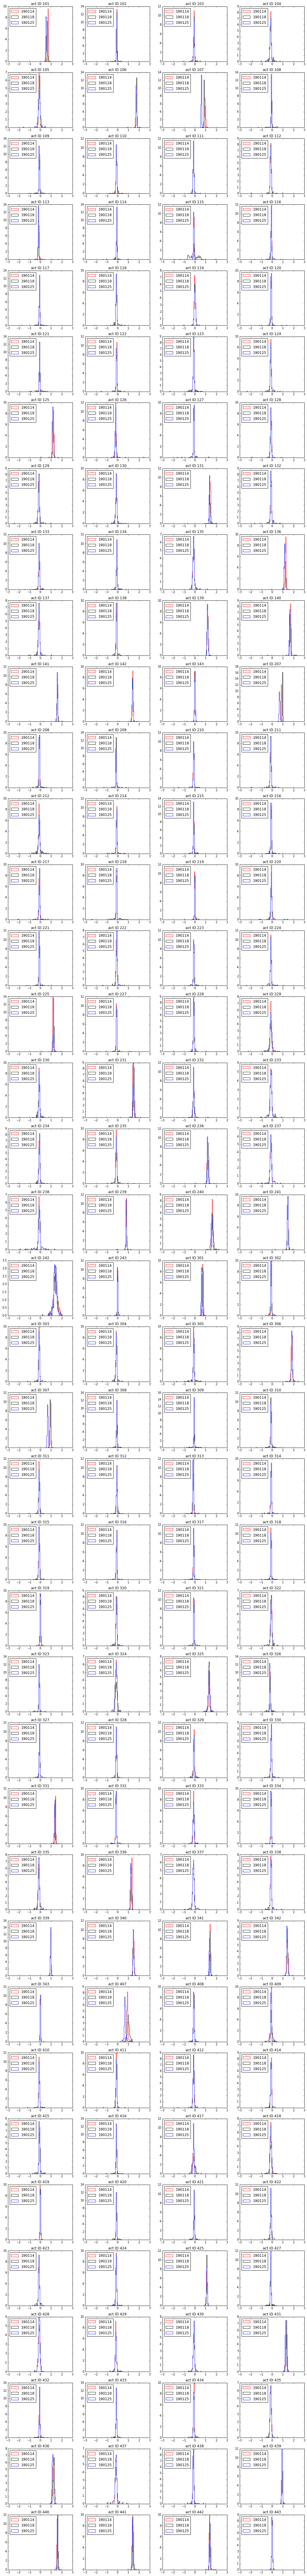

In [25]:
fig, ax = plt.subplots(39, 4, figsize = (18,4*39))
for i in range(nActuator):
    irow = np.int8(i/4)
    icol = np.mod(i,4)
    idx = ~np.isnan(fdiff2[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
    ax[irow][icol].hist(fdiff2[idx,i,3].reshape(-1,1), bins=xbin, color='r',histtype='step', density=True, label='190114')
    idx = ~np.isnan(fdiff3[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
    ax[irow][icol].hist(fdiff3[idx,i,3].reshape(-1,1), bins=xbin, color='k',histtype='step', density=True, label='190118')
    idx = ~np.isnan(fdiff[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
    ax[irow][icol].hist(fdiff[idx,i,3].reshape(-1,1), bins=xbin, color='b',histtype='step', density=True, label='190125')    
    ax[irow][icol].set_title('act ID %d'%actID[i])
    ax[irow][icol].legend(loc='upper left')

In [26]:
myFoffset = np.zeros((nActuator,4))
myFoffset[:,0] = actID
idx = ~np.isnan(fdiff[:,np.argmax(idxx),1]) #for 1st dimension: there are empty bins even after binning by dt=1s.
myFoffset[idxx,1] = np.mean(fdiff[np.ix_(idx,idxx)][:,:,1], axis=0)
myFoffset[idxy,2] = np.mean(fdiff[np.ix_(idx,idxy)][:,:,2], axis=0)
myFoffset[:,3] = np.mean(fdiff[idx,:,3], axis=0)
for i in range(nActuator):
    print('%d\t%.3f\t%.3f\t%.3f'%(myFoffset[i,0],myFoffset[i,1],myFoffset[i,2],myFoffset[i,3] ))

101	0.000	0.000	0.550
102	0.000	-0.017	-0.096
103	0.000	0.004	-0.080
104	0.000	-0.007	-0.141
105	0.000	-0.007	-0.094
106	0.000	0.000	1.754
107	0.000	0.000	0.613
108	0.000	0.017	-0.072
109	0.000	-0.009	-0.107
110	0.000	0.007	-0.109
111	0.000	-0.002	-0.125
112	0.006	0.000	-0.130
113	0.000	-0.011	-0.175
114	0.000	-0.014	-0.081
115	0.000	0.001	-0.106
116	0.000	0.002	-0.086
117	0.000	0.014	-0.082
118	0.000	-0.008	-0.118
119	0.000	0.000	-0.001
120	0.000	0.002	-0.098
121	0.000	0.008	-0.080
122	0.000	-0.001	-0.100
123	0.000	0.009	-0.107
124	0.000	0.001	-0.130
125	0.000	0.000	1.162
126	0.000	-0.001	-0.187
127	0.000	0.006	-0.095
128	0.001	0.000	-0.110
129	0.000	-0.026	-0.147
130	0.000	0.001	-0.123
131	0.000	0.000	1.363
132	0.000	-0.001	-0.099
133	0.000	-0.002	-0.115
134	0.000	-0.000	-0.070
135	-0.010	0.000	-0.118
136	0.000	0.000	1.174
137	0.000	-0.008	-0.123
138	0.000	0.009	-0.096
139	0.000	0.000	1.177
140	0.000	0.000	1.649
141	0.000	0.000	1.575
142	0.000	0.000	1.398
143	0.000	0.000	-0.000
207	0

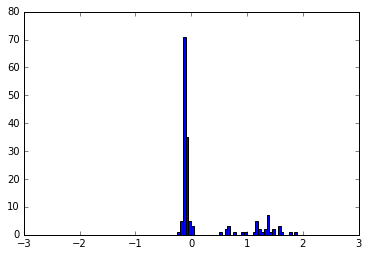

In [27]:
#this should look roughly like the overall plot above.
#it is a little different because here each entry is for one actuator. 
#Above each actuator contributed to one entry every second in time.
a=plt.hist(myFoffset[:,3], bins=xbin)

In [28]:
np.savetxt('data/myFoffset.txt', myFoffset)